## Introduction
Where did data come from?

The material id needs to be prepended by "mp-". The job is performed below

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join(''))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# print (module_path)

# from utils.editdf import EditFile 

# ed = EditFile()
# ed.generateFile('assets/HalfHeusler.csv', 'assets/Heusler compound.csv')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# %pip install pymatgen
# %pip install sklearn
# %pip install --upgrade tensorflow
# %pip install keras

import os.path
import pandas as pd

# import pymatgen.core as pg
# from pymatgen.ext.matproj import MPRester
from math import sqrt
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# dirPath= 'drive/Mydrive/'
dirPath= 'assets/'
# dirPath= '../input/assets/'

In [3]:
path_to_file = dirPath + 'HalfHeusler.csv'
file_name = dirPath + 'Heusler compound.csv'

if (not os.path.exists(file_name)):
    print ("A formatted csv file is produced\n")
    df = pd.read_csv(path_to_file)
    print (df.head())

    id_list = df['Materials-ID'].to_list()

    n = df.columns[0]
    df.drop(n, axis=1, inplace=True)

    df[n] = ["mp-" + str(x) for x in id_list]
    print (df.head())

    df.to_csv(file_name, index = False)

- Lattice parameters, atomic radii and atomic masses. The atomic radius is calculated value and not the empirical values
- Python library 'pymatgen'

In [4]:
'''
The Element class is located in the core subpakage inside the periodic_table module. 
The link to the API documentation is below.

    https://pymatgen.org/pymatgen.core.periodic_table.html#pymatgen.core.periodic_table.Element

Similarly the material project APIs are hosted in the following module.

    https://pymatgen.org/pymatgen.ext.matproj.html?highlight=mprester#module-pymatgen.ext.matproj
'''

file_name_train = dirPath + 'Training data.csv'

if (not os.path.exists(file_name_train)):
    print ("Training data will be generated\n")

    heusler_df = pd.read_csv(file_name, header=0, usecols= ['Materials-ID', '4a-site', '4b-site', '4c-site'])
    data = []

    m = MPRester('fmdc9tZK1xE74JOq')
    for idx in heusler_df.index:
        mat_data = m.get_data(heusler_df['Materials-ID'][idx])
        lat = m.get_structure_by_material_id(heusler_df['Materials-ID'][idx])
        
        lat_const = lat.lattice.abc
        mag_moment = sum(lat.site_properties['magmom'])
        
        e1 = pg.Element(heusler_df['4a-site'][idx])
        e2 = pg.Element(heusler_df['4b-site'][idx])
        e3 = pg.Element(heusler_df['4c-site'][idx])

        x1 = e1.atomic_radius
        x2 = e2.atomic_radius
        x3 = e3.atomic_radius
        m1 = e1.atomic_mass
        m2 = e2.atomic_mass
        m3 = e3.atomic_mass
        
        
        x29 = m1+m2+m3
        x30 = x1+x2+x3
        x33 = (x29/3 -m1)
        x34 = (x29/3 -m2)
        x35 = (x29/3 -m3)
        x42 = (x30/3 -x1)
        x43 = (x30/3 -x2)
        x44 = (x30/3 -x3)
        x51 = (x1**2 + x2**2)
        x52 = (x1**2 + x3**2)
            
        data.append((x1,x2,x3,m1,m2,m3,m1**2,m2**2,m3**2,x1**2,x2**2,x3**2,
                     m1**3,m2**3,m3**3,x1**3,x2**3,x3**3,
                     sqrt(m1),sqrt(m2),sqrt(m3),sqrt(x1),sqrt(x2),sqrt(x3),
                     m2/m1, x3/m1, x2/x1,x3/x1, x29,x30,
                     ((m1**2+m2**2+m3**2)/3.)**2, ((x1**2+x2**2+x3**2)/3.)**2,
                     x33, x34, x35, abs(x33), abs(x34), abs(x35), x33**2, x34**2, x35**2,
                     x42, x43, x44, abs(x42), abs(x43), abs(x44), x42**2, x43**2, x44**2,
                     x51, x52,sqrt(x51), sqrt(x52), 
                     mat_data[0]["formation_energy_per_atom"], # mag_moment,
                     lat_const[0], lat_const[1], lat_const[2]
                    ))

    idx = []
    for i in range(1, 55):
        idx.append('x'+str(i))

#     idx.extend(['form_energy_per_atom', 'total_magnetic_moment','a', 'b', 'c'])
    idx.extend(['form_energy_per_atom','a', 'b', 'c'])
    df_train = pd.DataFrame(data, columns = idx)

    df_train.to_csv(file_name_train, index = False)

## Machine Learning
The gradient boosted trees are selected for the regression task. The cross-validation is the first step.



### Cross-Validation
A five fold cross validation will be performed for the better performance of the model.

In [5]:
# The seed is required for replication of results. Parameters defined.
seed = 44
n_cols = 7
out_nodes = 1

df = pd.read_csv(dirPath + 'Training data.csv', usecols= ['x1', 'x2', 'x3','x4', 'x5', 'x6','form_energy_per_atom', 'a'])
# df = pd.read_csv(dirPath + 'Training data.csv')

X = df.iloc[:, :n_cols]
y = df.iloc[:, -1*out_nodes]

k = 5
kf = KFold(n_splits=k)
scoreR2 = []
y_pred = []

gbReg = GradientBoostingRegressor(n_estimators=600, max_depth= 1, random_state= seed)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    gbReg.fit(X_train, y_train)
    y_pred.extend(gbReg.predict(X_train))
    
    scoreR2.append(gbReg.score(X_test, y_test))
    
print (sum(scoreR2)/k)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbReg.fit(X_train, y_train)
print (gbReg.score(X_test, y_test))

0.9279334973474889
0.9582280939426462


## Grid Search
Hyperparameter tuning

Best: 0.927933 using {'max_depth': 1, 'n_estimators': 600}


The score for best estimator: 

0.9582280939426462


0.918090 (0.044480) with: {'max_depth': 1, 'n_estimators': 150}
0.921782 (0.040665) with: {'max_depth': 1, 'n_estimators': 200}
0.923378 (0.038988) with: {'max_depth': 1, 'n_estimators': 250}
0.923706 (0.038860) with: {'max_depth': 1, 'n_estimators': 260}
0.923763 (0.038700) with: {'max_depth': 1, 'n_estimators': 265}
0.923892 (0.038916) with: {'max_depth': 1, 'n_estimators': 270}
0.924085 (0.038689) with: {'max_depth': 1, 'n_estimators': 275}
0.924542 (0.038236) with: {'max_depth': 1, 'n_estimators': 300}
0.925220 (0.037334) with: {'max_depth': 1, 'n_estimators': 325}
0.927933 (0.033782) with: {'max_depth': 1, 'n_estimators': 600}
0.927878 (0.033677) with: {'max_depth': 1, 'n_estimators': 625}
0.927724 (0.033865) with: {'max_depth': 1, 'n_estimators': 650}
0.927031 (0.033664) with: {'max_depth': 1, 'n_estimators': 900}
0.903469 (0.059388) with: {'max_depth': 2, 'n_estimato

Text(0, 0.5, 'R2 score')

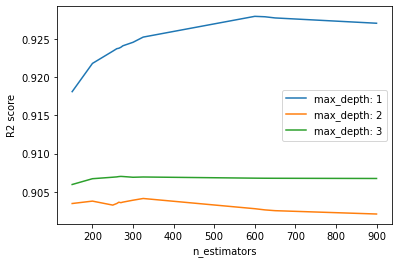

In [6]:
max_depth = [1, 2, 3]
n_estimators = [150, 200,250, 260, 265, 270, 275, 300, 325,600, 625, 650, 900]
# max_depth = [1,2]
# n_estimators = [325,600, 625, 650, 900]
param_grid = dict(max_depth=max_depth, n_estimators= n_estimators)

grid_search = GridSearchCV(gbReg, param_grid, scoring="r2", n_jobs=-1, cv=kf)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print ("\n")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

best_model = grid_result.best_estimator_
best_model.fit(X_train, y_train)
print ("The score for best estimator: \n")
print (best_model.score(X_test, y_test))

print ("\n")

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='max_depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('R2 score')

'\n    lr =0.1\n    max_depth/n_estimators= 1/625 or 3/270\n'

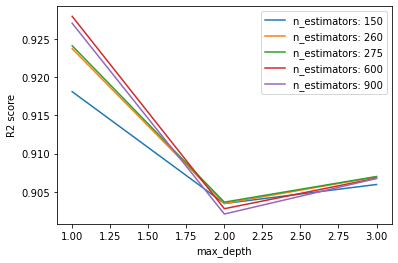

In [7]:
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(n_estimators):
    if i%3 ==0:
        plt.plot(max_depth, scores[:, i], label='n_estimators: ' + str(value))

plt.legend()
plt.xlabel('max_depth')
plt.ylabel('R2 score')

'''
    lr =0.1
    max_depth/n_estimators= 1/625 or 3/270
'''

## Neural Network 

The Boosted Trees performed very well. It was on par with the published paper. A juxtaposition with an artificial neural network would be interesting. The latter must me a better choice. 

ANN is easy to build especially after the introduction of Keras module in Tensorflow. 

### Scaling
Use MinMaxScaler

In [8]:
# The seed is required for replication of results. Parameters defined.
seed = 1111
n_cols = 7
out_nodes = 1

df = pd.read_csv(dirPath + 'Training data.csv', usecols= ['x1', 'x2', 'x3','x4', 'x5', 'x6','form_energy_per_atom', 'a'])
# df = pd.read_csv(dirPath + 'Training data.csv')

X = df.iloc[:, :n_cols]
y = df.iloc[:, -1*out_nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

trans = MinMaxScaler()
# trans = StandardScaler()
trans.fit(X_train)
X_train_scaled = trans.transform(X_train)
X_test_scaled = trans.transform(X_test)
X_scaled = trans.transform(X)

print (X_scaled[:5,:])
print ("")
print (y.head())
print ("")
print (X_train_scaled[:5,:])
print (X_test_scaled[:5,:])


[[0.47826087 0.39130435 0.47619048 0.16450411 0.51119424 0.93937595
  0.42391072]
 [0.34782609 0.2173913  0.23809524 0.         0.01449321 0.08717037
  0.88707022]
 [0.47826087 0.39130435 0.47619048 0.16450411 0.5277097  0.24162358
  0.25902818]
 [0.60869565 0.39130435 0.47619048 0.70100253 0.51119424 0.93937595
  0.36355118]
 [0.39130435 0.39130435 0.47619048 0.07514024 0.5277097  0.26611071
  0.76962006]]

0    4.611608
1    4.199121
2    4.320950
3    4.726488
4    4.412778
Name: a, dtype: float64

[[0.7826087  0.43478261 1.         0.57105744 0.         0.97680217
  0.96105767]
 [0.34782609 0.69565217 0.28571429 0.         0.08540932 0.32351412
  0.25353922]
 [0.30434783 0.39130435 0.47619048 0.17710143 0.51119424 0.92987616
  0.37119483]
 [0.69565217 0.52173913 0.52380952 0.59415051 1.         0.48246097
  0.27326742]
 [0.30434783 0.34782609 0.42857143 0.17710143 0.55933275 0.45546386
  0.56535306]]
[[ 0.65217391  0.39130435  0.47619048  0.65044078  0.5277097   0.24162358
   0.268

## The parameters

#### 6,4500-4800 best so far for epoch 2000-2500

(2, 600)/({nl-3, nn-800/nn-600, ep-2000}: 0.89)

({nl-5, nn-3200, ep-1700}: 0.87)

({nl-5, nn-3500, ep-1800}: 0.906)

5, 2500-3500 epochs 500

7, 2500 by GridSearchCV in kaggle
3, 1200 for one column output for epoch 850

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

# tolerance_value = 90

# checkpoint
filepath="model-single-out.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_r_square', verbose=1, 
                             save_best_only=True, mode='max')
# earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=tolerance_value)

callbacks_list = [checkpoint]

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/SS_tot + K.epsilon())


In [10]:
# n_epochs = 2500
# layers = 6
# neural_nodes = 4700

# def build_model(n_hidden=layers, n_neurons=neural_nodes, learning_rate=1e-4, input_shape=[n_cols,]):
#     model = keras.Sequential()
#     model.add(keras.layers.InputLayer(input_shape=input_shape))
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="sigmoid"))
#     model.add(keras.layers.Dense(out_nodes))

#     model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=[r_square])

#     return model

# # The wrapper is neccessary for GridSearch later in this notebook
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# # The history dictionary is useful for 'loss' plot of the model. In this case, the 'loss' is mean absolute error 
# history = keras_reg.fit(X_train_scaled, y_train, epochs=n_epochs,validation_data=(X_test_scaled, y_test),
#                         callbacks=callbacks_list)

# # Test on the holdout data
# mse_test = keras_reg.score(X_test_scaled, y_test)
# y_pred = keras_reg.predict(X_test_scaled)

# plt.figure()
# plt.plot(history.history['r_square'])
# plt.plot(history.history['val_r_square'])
# plt.ylim(0.85,1)
# plt.xlim(250)
# plt.title("Model co-efficient of determination")
# plt.ylabel("R-squared score")
# plt.xlabel("Epoch")
# plt.legend(["Train", "Test"])
# plt.show()

# # print ("\n The predicted values (Lattice constants)")
# print (y_pred)
# print ("\n The mean square error (MSE)")
# print (mse_test)
# print ("\n The R-square metric is")
# print (r_square(tf.convert_to_tensor(value=y_test.values, dtype='float32'), y_pred).numpy())

In [11]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error

# model = keras.Sequential()
# model.add(keras.layers.InputLayer(input_shape=[n_cols,]))

# for layer in range(layers):
#     model.add(keras.layers.Dense(neural_nodes, activation="sigmoid"))

# model.add(keras.layers.Dense(out_nodes))
# model.load_weights(filepath)
# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=lr), metrics=[r_square])

filepath="model-single-out.best.hdf5"
model = load_model(filepath, compile= False)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=[r_square])

# Test on the holdout data
scores = model.evaluate(X_test_scaled, y_test, verbose=0)
print("%s: %.2f" % (model.metrics_names[1], scores[1]))
y_pred = model.predict(X_test_scaled)

print ("\n The predicted values (Lattice constants)")
print (y_pred)
print ("\n The mean square error (MSE)")
print (mean_squared_error(y_test.values, y_pred))
print ("\n The R-square metric is")
print (r2_score(y_test.values, y_pred))


r_square: 0.95

 The predicted values (Lattice constants)
[[4.58301  ]
 [4.4463677]
 [4.4604726]
 [4.3481803]
 [5.278279 ]
 [4.447469 ]
 [5.5456147]
 [4.8476853]
 [4.8865094]
 [4.615806 ]
 [4.6911206]
 [4.3739886]
 [4.7683463]
 [4.6052165]
 [4.380063 ]
 [4.7447453]
 [4.350493 ]
 [4.3070564]
 [4.7059083]
 [4.3118405]
 [4.6909065]
 [4.7458844]
 [3.7161393]
 [4.521354 ]
 [4.744876 ]
 [5.032394 ]
 [4.3046393]
 [4.8820043]
 [4.770438 ]]

 The mean square error (MSE)
0.007369427394106579

 The R-square metric is
0.9450786926806061


## Grid Search

The hyperparamter tuning for NN.

In [12]:
# # tolerance_value = 50
# from sklearn.metrics import make_scorer

# # coefficient of determination (R^2) for regression  (only for Keras tensors)
# def r_square(y_true, y_pred):
# #     y_true = tf.convert_to_tensor(value=y_true, dtype='float32')
   
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return (1 - SS_res/(SS_tot + K.epsilon())).numpy()

# param_distribs = {
# #     "n_hidden": [4, 5, 6, 7, 8],
# #     "n_neurons": [1500, 2000, 2500, 3000, 3500, 4000],
#     "n_hidden": [5],
#     "n_neurons": [2500, 3000, 3500, 4000],
# }

# search_cv = GridSearchCV(estimator= keras_reg,
#                          param_grid= param_distribs, 
#                          cv= 4,
#                          scoring =make_scorer(r_square))

# grid_result = search_cv.fit(X_scaled, y.to_numpy())
# #                 validation_data=(X_test_scaled, y_test),
#                 # callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=tolerance_value)])

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("mean: %f, std: (%f) parameters: %r" % (mean, stdev, param))

In [13]:
# best_model = grid_result.best_estimator_

# print ("\nHistory object\n")
# best_model_history = best_model.fit(X_train_scaled, y_train, epochs=n_epochs,
#               validation_data=(X_test_scaled, y_test),
#               callbacks=[keras.callbacks.EarlyStopping(patience=tolerance_value)])

# y_pred = best_model.predict(X_test)              

# plt.figure()
# plt.plot(best_model_history.history['loss'])
# plt.plot(best_model_history.history['val_loss'])
# plt.title("Model loss")
# plt.ylabel("Mean Square Error (MSE) - Loss")
# plt.xlabel("Epoch")
# plt.legend(["Train", "Test"])
# plt.show()

# print ("\n Best Model's Parameters")
# print (best_model.get_params())
# print ("\n The mean square error (MSE)")
# print (best_model.score(X_test, y_test))
# print ("\n The R-square metric is")
# print (r_square(tf.convert_to_tensor(value=y_test.values, dtype='float32'), y_pred))
# print ("\n The predicted values (Lattice constants)")
# print (y_pred)

In [14]:
# from google.colab import files
# files.download('example.txt') 

In [15]:
# %cd /kaggle/working

# from IPython.display import FileLink
# FileLink(r'weights-single-out.best.hdf5')